<a href="https://colab.research.google.com/github/jjyjung/ai/blob/gh-pages/tf_keras_RNN_IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IMDB (Internet Movie DataBase ) – movie reviews sentiment classification**
* IMDB https://www.imdb.com/interfaces/
* https://keras.io/datasets/#imdb-movie-reviews-sentiment-classification
* Binary classification: Dataset of 25,000 movies reviews from IMDB, labeled by sentiment (positive[1]/negative[0]).
* Each review is encoded as a sequence of word indexes (integers).
* For convenience, words are indexed by overall frequency in the dataset, so that for instance the integer “3” encodes the 3rd most frequent word in the data.
* This allows for quick filtering operations such as: “only consider the top 10,000 most common words, but eliminate the top 20 most common words”.
 - e.g.  imdb.load_data(num_words=10000, skip_top=20)
* As a convention, "0" does not stand for a specific word, but instead is used to encode any unknown word.

In [1]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [38]:
## IMDB 데이터 추출 설정
max_features = 10000  # 사용할 단어의 최대 개수
maxlen = 500   # 한 영화리뷰의 최대 단어 길이
skip_top = 20  # 너무 일반적인 단어 20개는 제외함

(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features, skip_top=skip_top)

# 기준보다 단어 개수가 짧은 영화리뷰는 나머지를 0으로 패딩시킴
X_train = sequence.pad_sequences(input_train, maxlen=maxlen)  # 기본값 padding='pre' (왼쪽을 0으로 채움. 'post'는 오른쪽을 채움)
X_test = sequence.pad_sequences(input_test, maxlen=maxlen)

In [39]:
print(X_train.shape)
print(X_test.shape)
print(X_train.max(), X_train.min())
print(y_train, y_train.shape)
print(y_test, y_test.shape)

(25000, 500)
(25000, 500)
9999 0
[1 0 0 ... 0 1 0] (25000,)
[0 1 1 ... 0 0 0] (25000,)


In [40]:
type(y_train)

numpy.ndarray

In [41]:
print(input_train[3:5])
print(len(input_train[3]), len(input_train[4]))

print(X_train[3:5])
print(len(X_train[3]), len(X_train[4]))

[list([2, 2, 2, 2, 33, 2804, 2, 2040, 432, 111, 153, 103, 2, 1494, 2, 70, 131, 67, 2, 61, 2, 744, 35, 3715, 761, 61, 5766, 452, 9214, 2, 985, 2, 2, 59, 166, 2, 105, 216, 1239, 41, 1797, 2, 2, 2, 35, 744, 2413, 31, 2, 2, 687, 23, 2, 2, 7339, 2, 3693, 42, 38, 39, 121, 59, 456, 2, 2, 2, 265, 2, 575, 111, 153, 159, 59, 2, 1447, 21, 25, 586, 482, 39, 2, 96, 59, 716, 2, 2, 172, 65, 2, 579, 2, 6004, 2, 1615, 2, 2, 2, 5168, 2, 2, 7064, 2, 2, 2, 464, 31, 314, 2, 2, 2, 719, 605, 2, 2, 202, 27, 310, 2, 3772, 3501, 2, 2722, 58, 2, 2, 537, 2116, 180, 40, 2, 413, 173, 2, 263, 112, 37, 152, 377, 2, 537, 263, 846, 579, 178, 54, 75, 71, 476, 36, 413, 263, 2504, 182, 2, 2, 75, 2306, 922, 36, 279, 131, 2895, 2, 2867, 42, 2, 35, 921, 2, 192, 2, 1219, 3890, 2, 2, 217, 4122, 1710, 537, 2, 1236, 2, 736, 2, 2, 61, 403, 2, 2, 40, 61, 4494, 2, 27, 4494, 159, 90, 263, 2311, 4319, 309, 2, 178, 2, 82, 4319, 2, 65, 2, 9225, 145, 143, 5122, 2, 7039, 537, 746, 537, 537, 2, 7979, 2, 2, 594, 2, 5168, 94, 9096, 3987, 2,

In [42]:
# 단어별 인덱스 확인하기
word_to_index = imdb.get_word_index(path='imdb_word_index.json')
print(len(word_to_index))

index_to_word = {}
for key, value in word_to_index.items():
    index_to_word[value+3] = key   # IMDB의 word index 1,2,3은 특별 토큰임. 4부터 실제 단어임.

88584


In [43]:
list(index_to_word.items())[:20]

[(34704, 'fawn'),
 (52009, 'tsukino'),
 (52010, 'nunnery'),
 (16819, 'sonja'),
 (63954, 'vani'),
 (1411, 'woods'),
 (16118, 'spiders'),
 (2348, 'hanging'),
 (2292, 'woody'),
 (52011, 'trawling'),
 (52012, "hold's"),
 (11310, 'comically'),
 (40833, 'localized'),
 (30571, 'disobeying'),
 (52013, "'royale"),
 (40834, "harpo's"),
 (52014, 'canet'),
 (19316, 'aileen'),
 (52015, 'acurately'),
 (52016, "diplomat's")]

In [44]:
# 빈도가 많은 20개 단어 확인하기
sorted_index_to_word = dict(sorted(index_to_word.items()))
list(sorted_index_to_word.items())[:20]

[(4, 'the'),
 (5, 'and'),
 (6, 'a'),
 (7, 'of'),
 (8, 'to'),
 (9, 'is'),
 (10, 'br'),
 (11, 'in'),
 (12, 'it'),
 (13, 'i'),
 (14, 'this'),
 (15, 'that'),
 (16, 'was'),
 (17, 'as'),
 (18, 'for'),
 (19, 'with'),
 (20, 'movie'),
 (21, 'but'),
 (22, 'film'),
 (23, 'on')]

In [45]:
# imdb의 word index 0, 1, 2. 3은 각각 <pad>: padding, <sos>: start of sentence, <unk>: unknown, <<UNUSED>
for index, token in enumerate(("<PAD>", "<START>", "<UNK>", "<UNUSED")):
  index_to_word[index] = token

In [46]:
print(' '.join([index_to_word[index] for index in X_train[0]]))
print(' '.join([index_to_word[index] for index in X_train[1]]))
print(' '.join([index_to_word[index] for index in X_train[2]]))
print(' '.join([index_to_word[index] for index in X_train[3]]))
print(' '.join([index_to_word[index] for index in X_train[4]]))

<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

In [47]:
max_features

10000

In [48]:
model = Sequential()
model.add(Embedding(max_features, 100, input_length=maxlen))  # Embedding(vocab_size, embedding_dim, input_length=200)
model.add(SimpleRNN(32
            #  activation="tanh",
            #  recurrent_activation="sigmoid",
            #  use_bias=True,
            #  kernel_initializer="glorot_uniform",
            #  recurrent_initializer="orthogonal",
            #  bias_initializer="zeros",
            #  unit_forget_bias=True
))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
hist = model.fit(X_train, y_train,
                   epochs=120,
                   batch_size=84,
                   callbacks=[EarlyStopping(monitor='val_loss', patience=8)],
                   validation_split=0.2)

Epoch 1/120
239/239 [==============================] - 40s 156ms/step - loss: 0.5669 - acc: 0.6956 - val_loss: 0.4076 - val_acc: 0.8252
Epoch 2/120
239/239 [==============================] - 37s 155ms/step - loss: 0.3327 - acc: 0.8620 - val_loss: 0.3978 - val_acc: 0.8242
Epoch 3/120
239/239 [==============================] - 37s 156ms/step - loss: 0.2244 - acc: 0.9140 - val_loss: 0.3916 - val_acc: 0.8404
Epoch 4/120
239/239 [==============================] - 37s 156ms/step - loss: 0.1393 - acc: 0.9507 - val_loss: 0.4555 - val_acc: 0.8368
Epoch 5/120
239/239 [==============================] - 39s 162ms/step - loss: 0.0703 - acc: 0.9772 - val_loss: 0.5111 - val_acc: 0.8060
Epoch 6/120
239/239 [==============================] - 38s 160ms/step - loss: 0.0377 - acc: 0.9890 - val_loss: 0.5496 - val_acc: 0.8224
Epoch 7/120
239/239 [==============================] - 39s 161ms/step - loss: 0.0204 - acc: 0.9938 - val_loss: 0.7497 - val_acc: 0.7598
Epoch 8/120
239/239 [===========================

In [49]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 500, 100)          1000000   
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 32)                4256      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,004,289
Trainable params: 1,004,289
Non-trainable params: 0
_________________________________________________________________


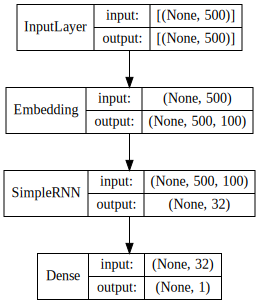

In [50]:
# visualize model structure
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot, plot_model

SVG(model_to_dot(model, show_shapes=True, show_layer_names=False,
                 rankdir='TB', dpi=72).create(prog='dot', format='svg'))

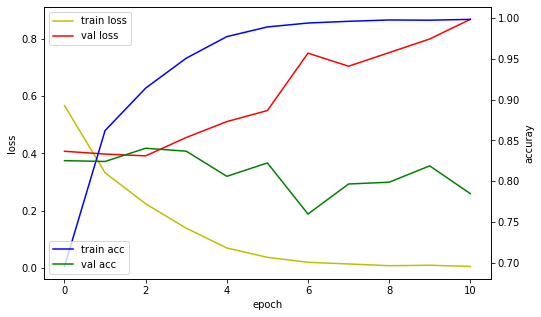

In [51]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(8, 5))

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [52]:
score = model.evaluate(X_test, y_test)
print('test_loss: ', score[0])
print('test_acc: ', score[1])

782/782 [==============================] - 24s 31ms/step - loss: 0.8695 - acc: 0.7873
test_loss:  0.8694810271263123
test_acc:  0.7872800230979919
